<a href="https://colab.research.google.com/github/tuanaasuokturk/MBC_data_analysis/blob/main/Assignment_3_ipynb_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3 - Psychometric curves and maximum likelihood estimation
**In this assignment, we will see how to study binary decisions:**
- using the **psychometric curve** to describe how decisions depend on a single stimulus feature
- define the **psychometric model** as a simple statistical model that links one property of the stimulus with participant choices
- learn about the generic concept of **maximum likelihood estimation** to fit a statistical model to experimental data


### Experiment, scientific question and objectives
In this assignment and in assignment 4, we will investigate data from a working memory [study](https://journals.physiology.org/doi/full/10.1152/jn.00362.2015) focusing  on the **binary response** experiment (Experiment 1, 8 participants, see Figure 3). In brief, participants were faced with circular arrays of stimuli (3 or 4 colored dots) while fixating. Following the delay period (delays were variable and could be 0.1, 1 or 3 seconds) a colored probe stimulus appeared slightly displaced relative to the color-matching cue stimulus (with an **angular displacement of 4°,6° or 8° either clockwise or counter-clockwise**). Participants had to **indicate with a button press whether this displacement was in the clockwise (CW, response 1) or counter-clockwise (CCW, response -1) direction**. (See figure below taken from Figure 3 of the article)

Apart from the angular displacement of the target w.r.t. the probe, there are **three other experimental variables** that vary from trial to trial: **memory load** (3 or 4 items), **delay duration** (0.1, 1 or 3 s), and whether the **nearest distractor is located CW or CCW to the target**.

We want to understand how these factors of interest impact the behavior, which will help us draw some conclusions about the properties of visual working memory. Specifically, we want to **test whether distractor stimuli have an attracting effect on the item represented in working memory**. By addressing this real research question, we will learn the main concepts and associated methods to analyze binary choice datasets:
 - psychometric curve, to relate the performance to a single factor of interest
 - logistic regression, to relate the performance to multiple factors of interest
 - interactions (to identify possible interactions of these factors)

![Task](https://raw.githubusercontent.com/wimmerlab/MBC_data_analysis/main/A3_PsychometricCurves/almeida2015_fig3.png)

 Let's start by importing the typical libraries (Numpy for basic data operation, Matplotlib for plotting, Pandas to deal with dataframes).

In [1]:
#we first load packages that we will need
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Importing the data
First thing first, let's import the data. Now that you're familiar with Pandas, we will directly import the data (stored as a CSV file) into a dataframe using the function `pd.read_csv`. As for previous assignments, each row in the table correspond to a trial. The columns contain the experimental variables for the corresponding trial: subject response (1=CW, -1=CCW); angle of the probe stimulus ("probe"); angle of the target ("target"); angle of nearest non-target ("near"); subject number; trial load (3 items/4 items, "load"); delay duration (0.1/1/3 seconds, "delay"). Here, all angles are expressed in degrees (not radians)!


In [2]:
# load the data
df = pd.read_csv("https://raw.githubusercontent.com/wimmerlab/MBC_data_analysis/main/A3_PsychometricCurves/Experiment1_all_subjects.csv",sep=',')

# visualize the first 10 rows
df.head(10)

,subject,load,delay,target,probe,near,response
0,1,3,0.1,24,18,10,-1
1,1,3,0.1,307,311,296,-1
2,1,3,0.1,151,147,289,1
3,1,4,0.1,326,334,32,-1
4,1,3,0.1,73,77,60,-1
5,1,3,0.1,85,79,70,1
6,1,4,0.1,213,219,226,-1
7,1,4,0.1,250,258,301,-1
8,1,4,0.1,102,108,114,1
9,1,3,0.1,232,238,133,-1


## 1. Plotting the psychometric curve

In this experiment the relevant property that determines the choice of the subject (CW/CCW) is the angular displacement between the probe stimulus and the target stimulus. Let us first compute this displacement and add it to the dataframe. We will use the function `circdist` to compte the distance between two angles, as in previous assignments.

In [3]:
# 1. Define a function that takes two angles as input and outputs the angular distance between the two
# compute the circular distance between two angles
def circdist(angles1, angles2):  # define the name and set the arguments between parentheses
    angle_diff = angles1 - angles2  # angle difference
    angle_diff = angle_diff  / 180 * np.pi  # convert to radian
    output = np.angle(np.exp(1j * angle_diff))  # mathematical operation to get the circular distance
    output = output / np.pi * 180   # convert back to degrees
    return output  # return the circular distance in degrees

# 2. Compute the displacement of the probe from the target and add it as a new column to the dataframe:
df['displacement'] = circdist( df['probe'], df['target'] );

# 3. Check that what we did makes sense (positive values should indicate CCW displacements of the probe)
df.head(10)

,subject,load,delay,target,probe,near,response,displacement
0,1,3,0.1,24,18,10,-1,-6.0
1,1,3,0.1,307,311,296,-1,4.0
2,1,3,0.1,151,147,289,1,-4.0
3,1,4,0.1,326,334,32,-1,8.0
4,1,3,0.1,73,77,60,-1,4.0
5,1,3,0.1,85,79,70,1,-6.0
6,1,4,0.1,213,219,226,-1,6.0
7,1,4,0.1,250,258,301,-1,8.0
8,1,4,0.1,102,108,114,1,6.0
9,1,3,0.1,232,238,133,-1,6.0


With the psychometric curve we want to capture **how the proportion of CW/CCW choices depend on the displacement of the probe w.r.t the target**. To do so, we want to group trials for each possible value of the angular displacement and compute the proportion of CW/CCW responses for each group separately.<br>
First let us check **how many different values the *displacement* measure takes**. Write the code below (reminder: we computed something similar in Assignment 0).

In [4]:
# compute the number of different values
nDisplacement = len(np.unique(df['displacement']))
print(nDisplacement)

6


**Is this the number you expected? Why?** Check the experimental design.

Yes, there are 3 different possible distances (4º, 6º or 8º) and two different directions (CW/CCW) so 2x3=6 possible values for the displacements: -8,-6,-4,4,6,8.

Ok so now let's focus on one value of the angular displacement (say +4º). **Compute the proportion of CCW responses for all trials where the angular displacement is of +4 degrees**.

In [5]:
# first we create a boolean array where value is TRUE if the angular distance is 4 degrees
meetConditions = df['displacement']==4

# select array of responses for all corresponding trial
response_displacement4 = df['response'][meetConditions]

# now compute the proportion of CCW responses for these trials
np.mean(response_displacement4==-1)

np.float64(0.6909722222222222)

We also want some idea of the reliability of this measure. For binary measures, we do not use the standard error of the mean but the following error function:

In [6]:
# this function takes a vector of binary variable as input and outputs the error about the mean
def binary_error(X):
    m = np.mean(X) # mean value
    err = np.sqrt(m*(1-m)/len(X)) # error: sqrt( mean*(1-mean)/nSamples)
    return err

**Use this function to compute the standard error for the mean proportion of CCW responses (in trial with distance = 4 degrees).**

In [7]:
binary_error(response_displacement4==-1)

np.float64(0.01925386010808333)

Good. Now we want to repeat this **for** all possible values of the displacement, which is why we're going to use a *for* loop. Fill in the code below to compute the mean and standard error for all values. Another option is to adapt the function `plot_data_psychometric` from the tutorial.

In [8]:
# initialize arrays for mean (and sem) as empty arrays (we will append values in the for loop)
mean_resp = []
sem_resp = []

# compute the unique values taken by the angular displacement
dist_unique = np.unique(df['displacement'])

# loop through all values of angular displacement
for x in dist_unique:
    # first we create a boolean array where value is TRUE if the angular displacement corresponds to the current value
    meetConditions = df['displacement']==x

    # responses for the corresponding trials
    subsetResp = df['response'][meetConditions]

    # boolean array that is true if the corresponding responses is CCW
    isCCW = subsetResp==-1

    # now compute the average proportion of CCW responses for these trials, and append
    mean_resp.append( np.mean(isCCW) )

    # and finally compute the standard error and append
    sem_resp.append( binary_error(isCCW) )

Now, let's plot the psychometric curve. If you have used `plot_data_psychometric` you have probably already plotted it. If not, check `plot_data_psychometric` how to do the plotting. Do not forget to **add labels on the axes**!

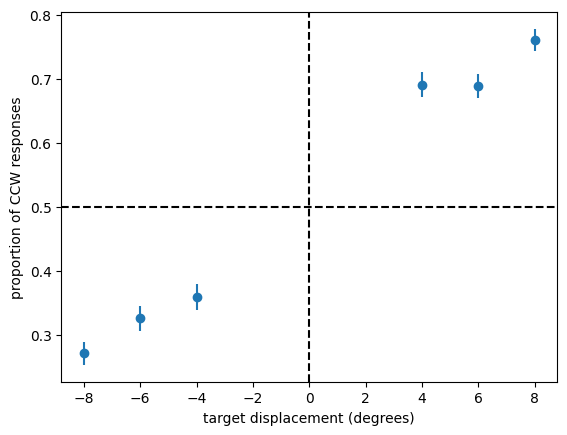

In [9]:
# plot points with errorbars
plt.errorbar(dist_unique ,mean_resp, yerr=sem_resp, fmt="o");

# add labels to the axes
plt.xlabel('target displacement (degrees)');
plt.ylabel('proportion of CCW responses');

# we add a vertical line at d=0 (i.e. when the target is at the same angle as the probe)
plt.axvline(x = 0, color = 'k', linestyle = '--')

#and horizontal line a pCCW = 0.5 (i.e. equal probability of CW and CCW responses)
plt.axhline(y = 0.5, color = 'k', linestyle = '--')


**Interpret the plot**.

As expected, we see more CCW than CW responses (i.e. Y values above 0.5) when the displacement is positive, i.e. the probe is located CCW to the target. Conversely, there are more CW than CCW responses (i.e. Y values below 0.5) when the displacement is negative, i.e. probe located CW to the target. In other words, subjects perform above chance (but very far from perfect). The larger is the distance in absolute values, the better are the subjects (i.e. the closer to 1 for CCW and 0 for CW).

Now this: there is a more compact way in python to use the for loop **within** a line command. See below how we are using it to compute the psychometric curves. This should give you the same plot as the one you found.

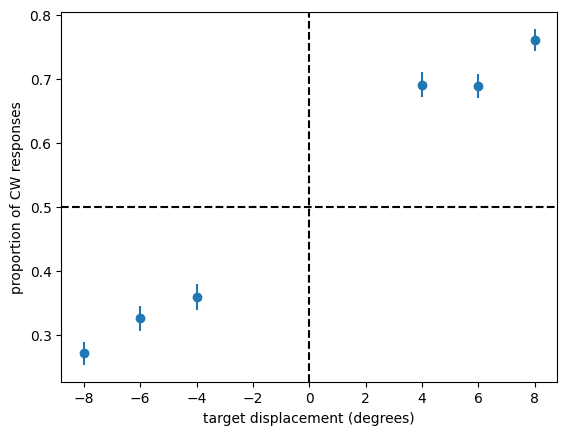

In [10]:
resp = df['response'] #the responses of the experiment
target_dist = df['displacement'] #the probe displacement shown
target_dist_unique = np.unique(target_dist) #the unique values of different probe_target distances shown

# here is the trick, we loop through unique values of distance to populate the array

#mean of responses, for each different probe_target distance
mean_resp =[np.mean(resp[target_dist==x]==-1) for x in target_dist_unique]

#sem of responses, for each different probe_target distance
sem_resp =[binary_error(resp[target_dist==x]==-1) for x in target_dist_unique]

plt.errorbar(dist_unique ,mean_resp, yerr=sem_resp, fmt="o");
plt.xlabel('target displacement (degrees)');
plt.ylabel('proportion of CW responses');

# we add a vertical line at d=0 (i.e. when the target is at the same angle as the probe)
plt.axvline(x = 0, color = 'k', linestyle = '--')

#and horizontal line a pCCW = 0.5 (i.e. equal probability of CW and CCW responses)
plt.axhline(y = 0.5, color = 'k', linestyle = '--')


## 2. The psychometric function
We now want to fit this data by the same psychometric function as used in the tutorial:

<br>$p(CCW) = \sigma(w_0 + w_1 d) = \frac{1}{1+ e^{-(w_0 + w_1 d)}}$, where $\sigma(x)$ is the logistic function

**Copy the necessary parts of the code from the tutorial.**

In [11]:
# let's define the logistic function
def logistic(x):
    y = 1 / (1 + np.exp(-x))
    return y

# define probability of rightward choices according to logistic model
def psychometric_model(s, w0, w1):
    """
    Computes the probability of rightward choices according to the logistic model
    Args:
        s (list): sensory evidence, for each trial
        w0 (scalar): regression weight
        w1 (scalar): regression weight
    Returns:
        list: probability of rightward choice, for each trial
    """

    # probability of rightward choice in control and manipulated condition
    p = logistic(w0 + w1 * s)

    return p


**Interpret the role of these two parameters in the model** (Hint: compare with simple linear regression)

$w_1$ sets the **sensitivity** of the dependent variable $p(CCW)$ on the factor $d$, i.e. the weight of $d$ on $p(CCW)$. The larger the value, the steeper the slope. $w_0$ sets the $bias$ of the curve (or the intercept, just as in linear regression). It sets the probability of CCW response when the factor is null (because $p(CCW|d=0) = \sigma(w_0+ w1*0) = \sigma(w_0)$. If $w_0$ is null, then at $d=0$ both responses are equally likely (since $\sigma(0)=0.5$). A positive value of $w_0$ means a bias towards CCW responses, a negative value means a bias towards CW responses.

### Fitting the psychometric curves

**Now plot the psychometric curve (that data) and the psychometric function (the model) in the same plot.**

**Either adjust the parameters of the model, w0 and w1, by hand, or use the optimization technique from the tutorial (optional).**

In the next Assignment, we will see how to run maximum-likelihood estimation for the psychometric model efficiently, using the framework of *logistic regression*.


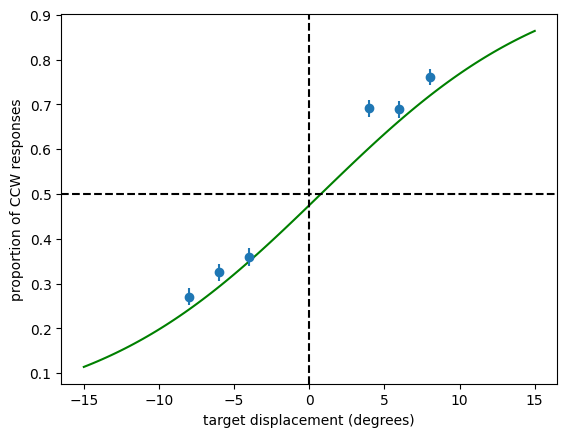

In [12]:
# copy here your code for plotting the psychometric model
# define the value of the parameters
w0 = -0.1
w1 = 0.13

# define an array of values spanning the range -15 to 15
d = np.linspace(-15,15,100)

# compute the corresponding p(CCW) for each of these values (using the function that we defined above)
pCCW = psychometric_model(d, w0, w1)

# plot
plt.plot(d,pCCW,'g-');

# we add a vertical line at d=0 (i.e. when the target is at the same angle as the probe)
plt.axvline(x = 0, color = 'k', linestyle = '--')

#and horizontal line a pCCW = 0.5 (i.e. equal probability of CW and CCW responses)
plt.axhline(y = 0.5, color = 'k', linestyle = '--')

# and copy here your plot for plotting the experimental psychometric curve
plt.errorbar(dist_unique ,mean_resp, yerr=sem_resp, fmt="o");
plt.xlabel('target displacement (degrees)');
plt.ylabel('proportion of CCW responses');

## 3. Assessing the influence of the distractors
Let's go back to our research question. So far what we have done is computing the proportion of CCW responses as a function of the angular displacement between the probe and the stimulus, and then fitting a statistical model that captures this relationship (the psychometric model). But all that really told us is that subjects seem to be the task appropriately, and the easier it is (the further away are the probe and the stimulus), the better they do. Reassuring, but perhaps not enough to make headlines... <br>
Really, what we are interested in is the influence of distractor on the behavior. More specifically, our hypothesis is that the nearest distractor may have an attractive effect on the representation stored in working memory. In other words, if the distractor is located CW to the target, the memory of the target should drift towards CW, and so by contrast the probe will look more displaced to CCW than it actually is, which should increase the probability of CCW responses. Conversely, if it is located CCW to the target, it should decrase this probability (go back to the figure of the paradigm if you don't get this). Let's explore this idea using the tools of psychometric curves. <br>
First, we need to define the angular distance between the target and the nearest distractor (to see whether it is located CW or CCW).
**Add a column called *'dist_distractor'* to the dataframe that computes this angular distance.**
(As always, we will try to use the functions that we have defined previously)
**Check that the value is positive if the distractor is located CCW to the target, negative otherwise.**

In [13]:
df['dist_distractor'] = circdist( df['near'] , df['target'] )
df.head(10)

,subject,load,delay,target,probe,near,response,displacement,dist_distractor
0,1,3,0.1,24,18,10,-1,-6.0,-14.0
1,1,3,0.1,307,311,296,-1,4.0,-11.0
2,1,3,0.1,151,147,289,1,-4.0,138.0
3,1,4,0.1,326,334,32,-1,8.0,66.0
4,1,3,0.1,73,77,60,-1,4.0,-13.0
5,1,3,0.1,85,79,70,1,-6.0,-15.0
6,1,4,0.1,213,219,226,-1,6.0,13.0
7,1,4,0.1,250,258,301,-1,8.0,51.0
8,1,4,0.1,102,108,114,1,6.0,12.0
9,1,3,0.1,232,238,133,-1,6.0,-99.0


Now **plot two psychometric curves** on the same figure:
- one corresponding to all trials where the nearest distractor was located CW to the target
- one corresponding to all trials where the nearest distractor was located CCW to the target
Because we expect the effect of the distractor to be larger for longer delays, **restrict your analysis to long delays** (either 1 or 3 s).

We will use the function *psycho_curve* defined below which computes the relevant values of the psychometric curves (displacements and corresponding mean and s.e.m. of CCW responses) from any arrays of displacement and responses. This way we compute the psychometric curve for a certain condition by providing as input to this function the arrays for trials in this condition. Take some time to understand how this function works, which variable it takes as input and which variable it outputs.

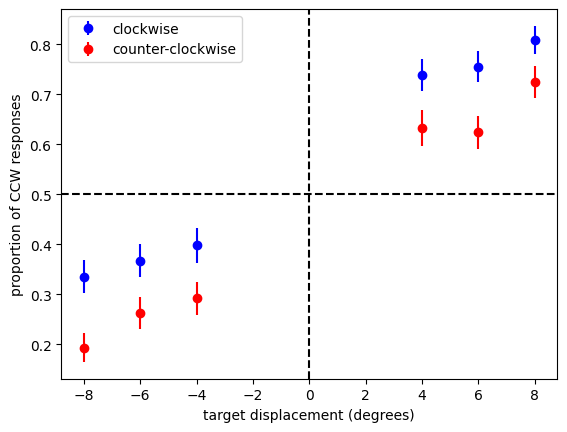

In [14]:
# function that computes (but does not plot) the psychometric curve for a sequence of trials
def psycho_curve(resp, target_dist):
    #the unique values of different probe_target distances shown
    target_dist_unique = np.unique(target_dist)

    #proportion of CCW responses
    mean_resp =[np.mean(resp[target_dist==x]==-1) for x in target_dist_unique]

    #sem of CCW proportion, for each different probe_target distance
    sem_resp =[binary_error(resp[target_dist==x]==-1) for x in target_dist_unique]

    # output the mean, sem and corresponding distance values
    return mean_resp, sem_resp, target_dist_unique


#array with the responses of the experiment (all trials)
resp = df['response']

#array with the target displacement (all trials)
target_dist = df['displacement']

# 1. Psychometric curve for trials with distractor located CW (and long delays)

# create a boolean array that is true iff the nearest distractor is located CW to the target
is_distractor_CW = df['dist_distractor'] < 0

# create a boolean array that is true iff the delay is long (1s or 3s, i.e. longer than 0.5 s)
is_long_delay = df['delay']>0.5

# create a boolean array that is true if both conditions above are met
# (what boolean operation is this?)
is_both = is_distractor_CW & is_long_delay

#select the responses and target distances for trials that match both conditions
resp_CW_longdelay = resp[is_both]
target_dist_CW_longdelay = target_dist[is_both]

#use the function we defined above to compute the psychometric curve for this set of trials
mean_resp_CW, sem_resp_CW, target_dist_unique = psycho_curve(resp_CW_longdelay, target_dist_CW_longdelay)

# 2. repeat the same operations for trials with CCW distractor (and again long delays)

# create a boolean array that is true iff the nearest distractor is located CW to the target
is_distractor_CCW = df['dist_distractor'] > 0

# create a boolean array that is true iff the delay is long (1s or 3s, i.e. longer than 0.5 s)
is_long_delay = df['delay']>0.5

# create a boolean array that is true if both conditions above are met
# (what boolean operation is this?)
is_both = is_distractor_CCW & is_long_delay

#select the responses and target distances for trials that match both conditions
resp_CCW_longdelay = resp[is_both]
target_dist_CCW_longdelay = target_dist[is_both]

#use the function we defined above to compute the psychometric curve for this set of trials
mean_resp_CCW, sem_resp_CCW, target_dist_unique = psycho_curve(resp_CCW_longdelay, target_dist_CCW_longdelay)


# 3. plot everything  (use option 'label=' to define a label for the legend)

plt.errorbar(dist_unique ,mean_resp_CW, yerr=sem_resp_CW, fmt="bo", label="clockwise");
plt.errorbar(dist_unique ,mean_resp_CCW, yerr=sem_resp_CCW, fmt="ro", label="counter-clockwise");

# we add a vertical line at d=0 (i.e. when the target is at the same angle as the probe)
plt.axvline(x = 0, color = 'k', linestyle = '--')

#and horizontal line a pCCW = 0.5 (i.e. equal probability of CW and CCW responses)
plt.axhline(y = 0.5, color = 'k', linestyle = '--')

plt.xlabel('target displacement (degrees)');
plt.ylabel('proportion of CCW responses');
plt.legend();

**How do you interpret the figure?**

We see that when distractor is located CW to the target, the proportion of CW responses is increased, irrespective of the value of the target displacement. This shows an **attracting effect of the distractor (at long delays)**.